<a href="https://colab.research.google.com/github/sapirca/wine_reviews/blob/main/Understanding_wine_trends_across_different_attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Predictive Wine Quality project

Authors - Eliezer Pekar 212029052 | Sapir Caduri 303083653


The goal of this research paper is to develop a predictive model to identify the quality of wine based on various attributes such as location, price, and others. The research is using a Wine Review dataset from Kaggle, that is motivated by the documentary "Somm" which explores the world of master sommeliers and their ability to identify wines through blind tasting.

## The predictive Task




In this paper we explore the relationship between wine attributes (e.g., price, rating, regions) and their quality - we assume that the higher the pricer the higher the rating, we can try to predict the rating of the winer based on the price.



## The Dataset

The Wine Reviews dataset contains information about various wines, including details such as country of origin, designation, points, price, province, region, variety, and winery. Number of rows: 119,955 (~25k unique reviews), 14  attributes


In [ ]:
# @title Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import contextlib
import seaborn as sns
from google.colab import files
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline   # Import the Pipeline class
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import StringIO

### Load dataset

In [ ]:
# @title Installations
!pip install -q kaggle


#### Setting up Kaggle API
To download datasets from Kaggle, we first need to set up the Kaggle API. This involves uploading the Kaggle API key (kaggle.json), moving it to the appropriate directory, and using Kaggle commands to download the dataset of interest.


In [ ]:
# @title Upload Kaggle.json api key
with StringIO() as temp_output, contextlib.redirect_stdout(temp_output):
    # This won't print to the screen the Kaggle API key
    files.upload()

In [ ]:
# Move the API key into the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#### Download the Wine Reviews Dataset from Kaggle

In [ ]:
!kaggle datasets download -d zynicide/wine-reviews
!unzip -q wine-reviews.zip -d wine-reviews
!ls ./wine-reviews


 67% 34.0M/50.9M [00:00<00:00, 67.6MB/s]
100% 50.9M/50.9M [00:00<00:00, 84.0MB/s]
winemag-data-130k-v2.csv  winemag-data-130k-v2.json  winemag-data_first150k.csv


In [ ]:
wine_data_1 = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv")
wine_data_1.shape

(129971, 14)

In [ ]:
wine_data_2 = pd.read_csv("./wine-reviews/winemag-data_first150k.csv")
wine_data_2.shape

(150930, 11)

In [ ]:
wine_data_3 = pd.read_json("./wine-reviews/winemag-data-130k-v2.json")
wine_data_3.shape

(129971, 13)

### Challenges with the data

The Wine Reviews dataset presents several challenges and difficulties that may arise during data analysis and modeling:
1. Missing Data/Empty rows: Designation 29% null, Null cells: Region 16% null, region2 61% null, taster_name 20% null, taster_twitter_handle 24% empty
2. Free text: The Description column contains textual descriptions of the wines
3. Biasing: Tiger Voss 20% of the reviews (@vossroger)
4. Outlier:
5. Imbalance: wine variety or quality = Some wine varieties or regions are heavily represented in the dataset = Pinot Noir 10%, Chardonnay 9%, other 81%, Region 2 9% Central coast
6. Categorical Variables: The dataset contains categorical variables such as "Winery" with 16K unique wineries (of 199K rows)
7. High Dimensionality: The dataset have a large number of attributes - can pose challenges for modeling and visualization

### Explaining the data (Data Analysis)

Let's look at each of the files separately:

In [ ]:
wine_data_1.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [ ]:
wine_data_2.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


#### "winemag-data-130k-v2.json"
The third file of the dataset includes the name of the tester and the tester's twitter account name

In [ ]:
wine_data_3.head(3)

,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,province,country,winery
0,87,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Kerin O’Keefe,@kerinokeefe,NaN,Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia
1,87,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Roger Voss,@vossroger,15.0,Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos
2,87,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Paul Gregutt,@paulgwine,14.0,None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm


In [ ]:
def print_wine_attributes(wine_data):
  print("Wine attributes: ")
  for idx, column_name in enumerate(wine_data.columns):
      if pd.api.types.is_numeric_dtype(wine_data[column_name]):
          value_min = wine_data[column_name].min()
          value_max = wine_data[column_name].max()
          print(f"{idx}. {column_name} (Range: {value_min} - {value_max})")
      else:
          print(f"{idx}. {column_name}")
          # print("   Range: Not applicable (non-numeric data)")
          pass

Let's examine each file's Wine attributes

In [ ]:
print_wine_attributes(wine_data_1)

Wine attributes: 
0. Unnamed: 0 (Range: 0 - 129970)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 3300.0)
6. province
7. region_1
8. region_2
9. taster_name
10. taster_twitter_handle
11. title
12. variety
13. winery


In [ ]:
print_wine_attributes(wine_data_2)

Wine attributes: 
0. Unnamed: 0 (Range: 0 - 150929)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 2300.0)
6. province
7. region_1
8. region_2
9. variety
10. winery


In [ ]:
print_wine_attributes(wine_data_3)

Wine attributes: 
0. points (Range: 80 - 100)
1. title
2. description
3. taster_name
4. taster_twitter_handle
5. price (Range: 4.0 - 3300.0)
6. designation
7. variety
8. region_1
9. region_2
10. province
11. country
12. winery


As it seems, the winemag-data_first150k.csv, is the most updated data file, it has three additional new fields: Title, Taster Name, and Taster Twitter Handle.
The author notes that this file also fix the duplicate entries problem in the first version of the dataset and add ~25k unique reviews.

In [ ]:
wine_data = wine_data_3

<Axes: xlabel='taster_name'>

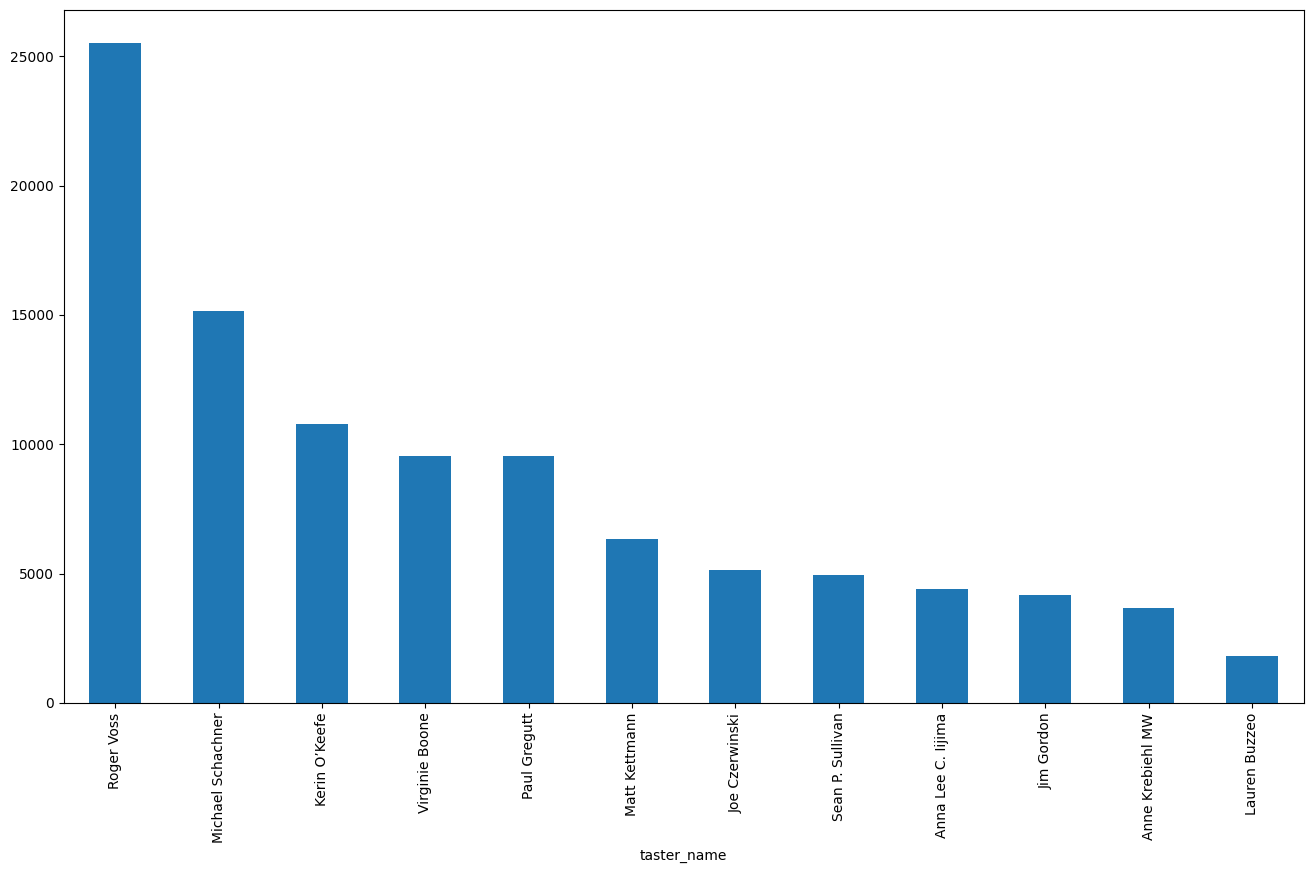

In [ ]:
plt.figure(figsize=(16,9))
wine_data['taster_name'].value_counts().head(12).plot.bar()

In [ ]:
reviews = wine_data

<Axes: xlabel='price', ylabel='points'>

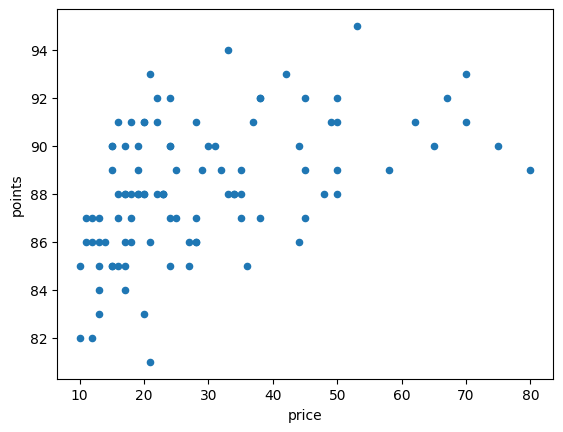

In [ ]:
reviews[reviews['price'] < 100].sample(100).plot.scatter(x='price', y='points')

<Axes: title={'center': 'Score Of wines'}, xlabel='points'>

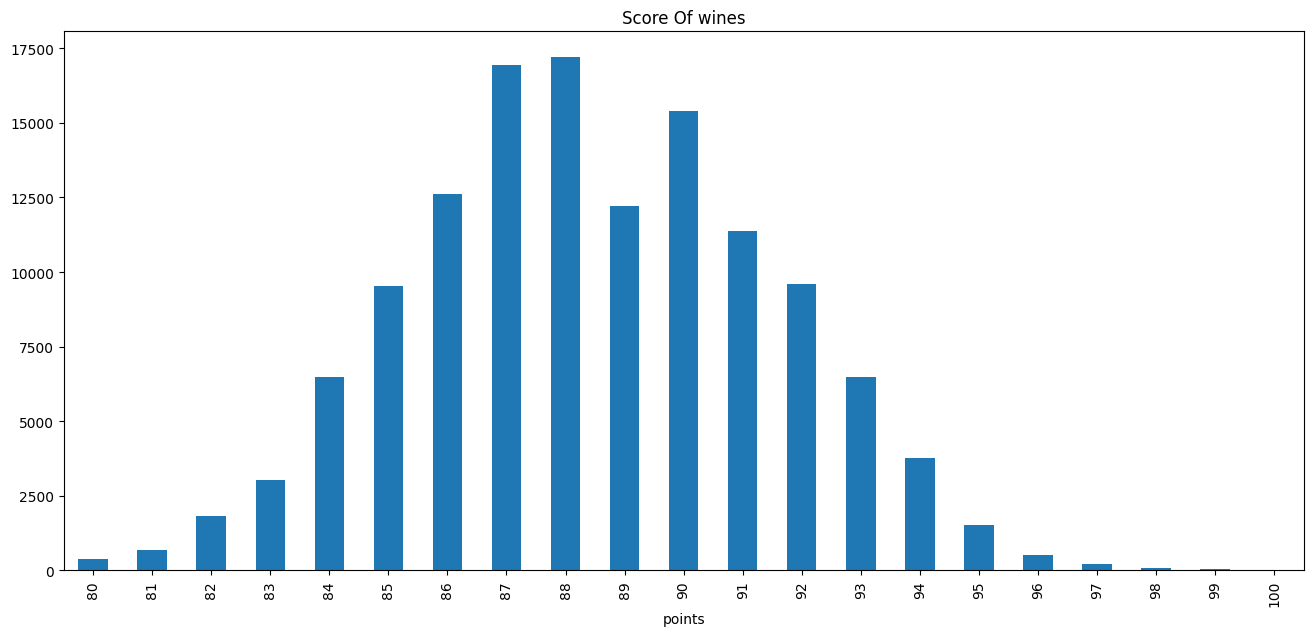

In [ ]:
plt.figure(figsize=(16,7))
reviews['points'].value_counts().sort_index().plot.bar(title = 'Score Of wines')

<Axes: title={'center': 'Prices of wine'}, xlabel='price'>

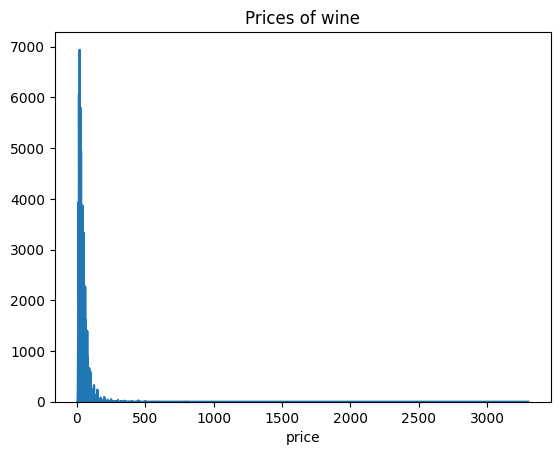

In [ ]:
reviews['price'].value_counts().sort_index().plot.area(
    title = 'Prices of wine'
)

<Axes: xlabel='variety', ylabel='points'>

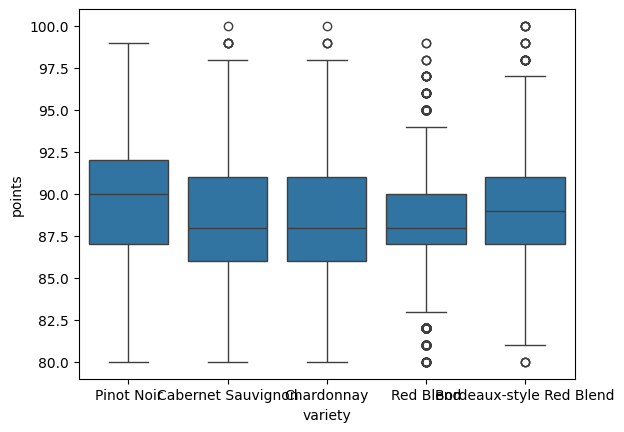

In [ ]:
df1 = reviews[reviews.variety.isin(reviews.variety.value_counts().head(5).index)]

sns.boxplot(
    x = 'variety',
    y = 'points',
    data = df1
)

# ML Model

### Common code

In [ ]:
df = reviews

## Build the training and test dataset

training: ['price', 'country', 'variety'] -> 'points' (predict wine score)

x: gold score, y: predicted score



In [ ]:
# Handling missing values
# drop rows with any missing value in 'Price', 'Country', or 'Variety'
df.dropna(subset=['price', 'country', 'variety'], inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])
df['variety'] = label_encoder.fit_transform(df['variety'])

# Select features and target
X = df[['price', 'country', 'variety']]
y = df['points']

### Split dataset to Train & test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Basic model using xgboost

## Training

In [ ]:
with StringIO() as temp_output, contextlib.redirect_stdout(temp_output):
  model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
  model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# Evaluating Basic Model

In [ ]:
def evaluate_model(y_true, predictions):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = mse ** 0.5
    # rmse = mean_squared_error(y_test, predictions, squared=False)  # Set squared=False for RMSE
    r2 = r2_score(y_true, predictions)

    # Mean Absolute Error (MAE): Measures the average magnitude of errors
    print(f"MAE:  {mae:.2f}")

    # Mean Squared Error (MSE): Averages squared errors, penalizing large errors more
    print(f"MSE:  {mse:.2f}")

    # Root Mean Squared Error (RMSE): Square root of MSE, in the same units as the original data
    print(f"RMSE: {rmse:.2f}")

    # R-squared (R²):  Represents the proportion of variance explained by the model
    print(f"R²:   {r2:.2f}")

In [ ]:
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1.8007980379490216


## Predicted vs Gold test

The scatter plot below reveals that the basic model's predictions deviate significantly from the ideal diagonal line, demonstrating limited accuracy. While the model shows a general ability to predict higher scores for higher quality wines, the slope of this trend doesn't match the ideal expectation. Additionally, the model exhibits a bias, initially overestimating scores for wines around 80 points and then underestimating scores for wines rated around 100 points.

These observations suggest the need for model refinement to improve its prediction accuracy and address the observed biases.

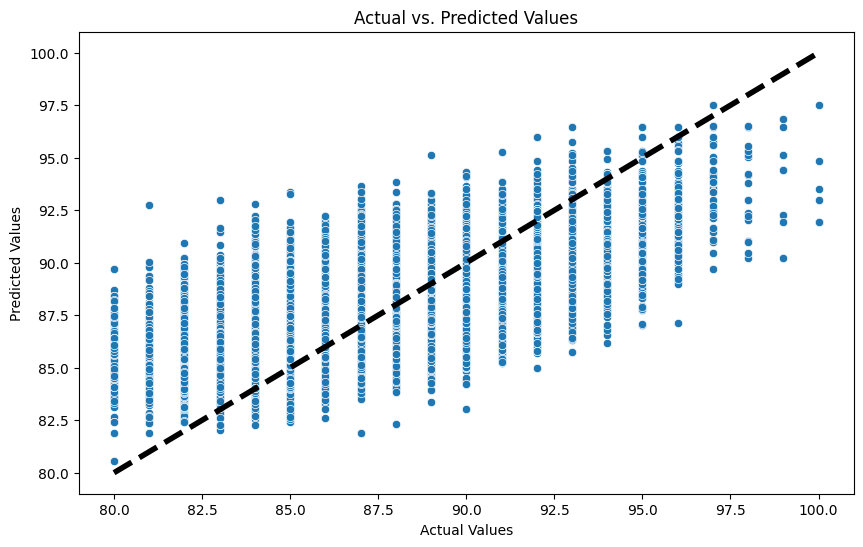

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# training: ['price', 'country', 'variety'] -> 'points' (predict wine score)
# x: gold score, y: predicted score

In [ ]:
evaluate_model(y_test, predictions)

MAE:  1.80
MSE:  5.20
RMSE: 2.28
R²:   0.44


# Model improvments

## Attempt 1: GradientBoostingRegressor

A first relatively naive attempt, would be to try and work with a different training arcithecture, results show this does not imporve the final score of the model, which brings us to the need to clean and arrange the data

In [ ]:
preprocessor = SimpleImputer(strategy='mean')  # Replace missing values with the mean
preprocessor = StandardScaler()

# Train
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
my_pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),('model', model_gb)])
my_pipeline_gb.fit(X_train, y_train)
# Test
predictions_gb = my_pipeline_gb.predict(X_test)

In [ ]:
evaluate_model(y_test, predictions_gb)

This isn't better than XGBRegressor

## Attempt 2: data extraction and cleaning

## Litrature Oveview